In [1]:
import sys
sys.path.append("../../pygenesig/")

%load_ext autoreload
%autoreload 1
%aimport pygenesig.validation
%aimport pygenesig.gini
%aimport pygenesig.bioqc
%aimport pygenesig.tools
%aimport pygenesig.perfmeasures
%matplotlib inline

from pygenesig.validation import * 
from pygenesig.gini import * 
from pygenesig.bioqc import * 
from pygenesig.tools import * 
import pygenesig.perfmeasures as pm
import numpy as np
import pandas as pd
import sklearn.metrics as skm 
import os.path
import os
import re

import seaborn as sns
sns.set_style("ticks", {"axes.grid" : True})
from pylab import * 

# Validate signatures based on FANTOM5 primary cells
This notebook aims at finding which samples from the FANTOM5 primary cells can be used to create meaningful signatures. 
We do this using cross-validation with two folds (there are often only two samples). 

When a signature is able to identify itself, the samples are 'good' and the signature appears to work. 

We first perform the crossvalidation and discard all samples that we could not validate and then re-create the signatures for the samples we did not discard. 

### Load data

In [2]:
expr_file = "../data/pygenesig/by_promotor/primary_exprs.npy"
target_file = "../data/pygenesig/primary_target_coarse.csv"
fdata_file = "../data/pygenesig/by_promotor/fdata.csv"
expr_by_gene_sum_file = "../data/pygenesig/by_gene_sum/primary_exprs.npy"
fdata_by_gene_sum_file = "../data/pygenesig/by_gene_sum/fdata.csv"
splitter = sklearn.model_selection.StratifiedKFold(n_splits=2)
sg_kwargs = {'min_gini': .8, 'max_rk': 3, 'min_expr': 5, 'max_rel_rk': .33}

In [3]:
expr = {
    "by_gene_sum": np.load(expr_by_gene_sum_file),
    "by_promotor": np.load(expr_file)
}
fdata = {
    "by_gene_sum": pd.read_csv(fdata_by_gene_sum_file),
    "by_promotor": pd.read_csv(fdata_file)
}

In [4]:
target = np.genfromtxt(target_file,  dtype=str, delimiter=",")

### perform cross-validation
... using *pygenesig*

We calculate the BioQC score for all signatures and all samples. We collapse samples of the same cell type, s.t we get a $n \times n$ scoring matrix. 

In [5]:
signatures = []
scores = []
score_mats = []
sg = GiniSignatureGenerator(expr["by_promotor"], target, aggregate_fun=np.median, **sg_kwargs)
st = BioQCSignatureTester(expr["by_promotor"], target)
for train, test in splitter.split(list(enumerate(target)), target):
    signature = sg.mk_signatures(train)
    score = st.score_signatures(signature, test)
    signatures.append(signature)
    sig_labels = st.sort_signatures(signature)
    scores.append(score)
    scores_df = pd.DataFrame(np.transpose(score))
    scores_df.columns = sig_labels
    scores_df['tissue'] = pd.Series(target[test])
    scores_per_sig = scores_df.groupby('tissue').mean().transpose()
    score_mats.append(scores_per_sig)

/home/sturm/projects/2019/pygenesig/pygenesig/validation.py:115: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if not np.issubdtype(expr.dtype, int) and not np.issubdtype(expr.dtype, float):
/home/sturm/projects/2019/pygenesig/pygenesig/validation.py:115: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(expr.dtype, int) and not np.issubdtype(expr.dtype, float):
/home/sturm/projects/2019/pygenesig/pygenesig/validation.py:204: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if not np.issubdtype(expr.dtype, int) and not np.issubdtype(expr.dtype, float):
/home/sturm/projects/201

### Average the scoring matrices and visualize it

In [6]:
avg = (score_mats[0] + score_mats[1])/2

Text(0.5, 204.0, 'mean of samples')

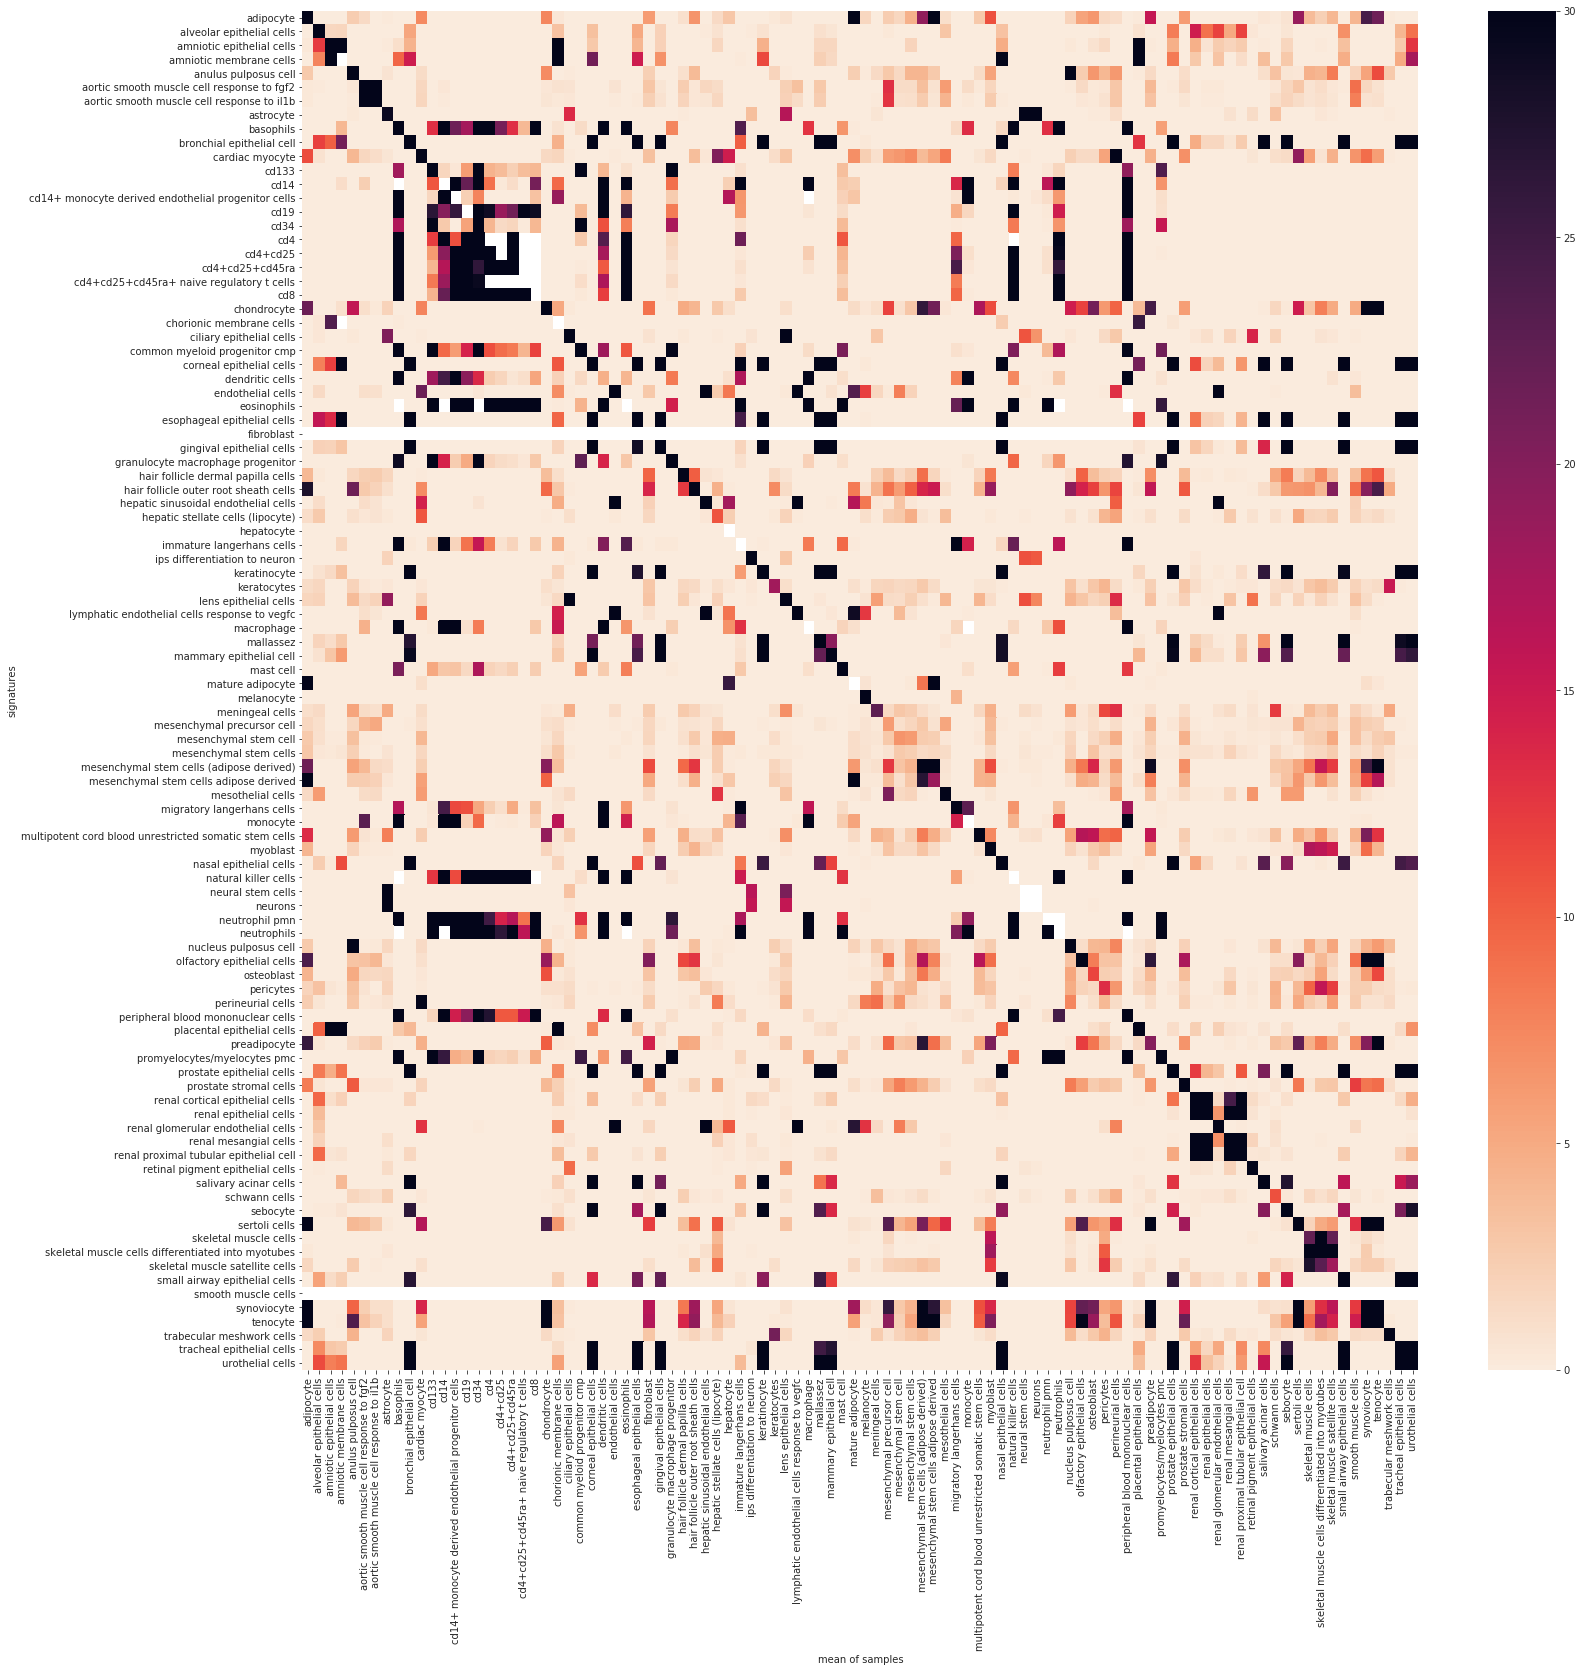

In [11]:
fig, ax = subplots(figsize=(25, 25))
sns.heatmap(avg, ax=ax, annot=False, annot_kws={"size": 9}, vmin=0, vmax=30, cmap=sns.cm.rocket_r);
ax.set_ylabel("signatures")
ax.set_xlabel("mean of samples")

Fibroblast shows *NaN* as the signature does not contain a single gene in the first fold. 

The scoring matrix: 

In [12]:
pd.set_option('display.max_rows', 100)
avg

tissue,adipocyte,alveolar epithelial cells,amniotic epithelial cells,amniotic membrane cells,anulus pulposus cell,aortic smooth muscle cell response to fgf2,aortic smooth muscle cell response to il1b,astrocyte,basophils,bronchial epithelial cell,...,skeletal muscle cells,skeletal muscle cells differentiated into myotubes,skeletal muscle satellite cells,small airway epithelial cells,smooth muscle cells,synoviocyte,tenocyte,trabecular meshwork cells,tracheal epithelial cells,urothelial cells
adipocyte,8.873314e+01,6.244702e-03,6.907155e-05,1.896533e-04,2.377806e+00,1.388120e+00,2.109821e-02,1.359532e-01,4.906016e-15,4.125326e-04,...,3.642253e+00,2.224725e+00,4.097325e+00,4.166036e-07,4.192650e+00,2.434838e+01,2.155164e+01,2.308137e-01,3.926021e-04,3.855976e-06
alveolar epithelial cells,3.456420e-03,6.072063e+01,1.574931e+00,1.643372e+00,2.780265e-03,2.509467e-02,1.875110e-02,3.276996e-02,1.144339e-02,5.385365e+00,...,4.636206e-03,1.823942e-03,4.165635e-03,6.874206e+00,8.311948e-02,1.107008e-03,1.530282e-05,9.033003e-05,4.178125e+00,8.951077e+00
amniotic epithelial cells,2.726702e-01,1.228908e+01,1.490646e+02,8.405714e+01,3.516340e-02,2.258953e-09,1.345799e-06,1.626436e-01,1.012071e+00,4.379021e+00,...,8.924792e-02,1.479090e-01,5.064950e-03,3.284844e+00,6.789391e-02,2.097636e-04,5.372691e-03,1.301325e-03,2.689665e+00,1.274884e+01
amniotic membrane cells,5.250233e-04,7.621174e+00,1.147072e+02,inf,3.543903e-15,0.000000e+00,0.000000e+00,0.000000e+00,9.624264e+00,1.479481e+01,...,1.405452e-10,1.291673e-11,0.000000e+00,4.770683e+00,2.444665e-09,0.000000e+00,4.785875e-10,0.000000e+00,5.008787e+00,1.761314e+01
anulus pulposus cell,2.631032e+00,1.463096e-03,3.014123e-05,3.859406e-05,5.567546e+01,1.714729e-02,2.416693e-02,6.646808e-01,5.824474e-09,6.314631e-04,...,4.513892e+00,4.107493e+00,8.302545e+00,9.127525e-07,1.762116e+00,5.507503e+00,1.119577e+01,2.616079e+00,4.186839e-05,5.417671e-05
aortic smooth muscle cell response to fgf2,2.648043e-01,1.930876e-01,3.421039e-06,8.174633e-04,3.680246e-01,6.575501e+01,6.338555e+01,3.108360e-02,3.092401e-03,8.853698e-04,...,6.713664e-01,1.130599e+00,4.314339e-01,1.933206e-01,9.086715e+00,1.626951e+00,8.081364e-01,7.905010e-03,9.351140e-03,2.291926e-03
aortic smooth muscle cell response to il1b,2.604955e-01,9.975581e-02,1.635951e-05,5.310538e-05,1.756910e-01,6.089276e+01,6.027959e+01,2.617471e-02,1.210251e-03,5.954614e-04,...,5.984847e-01,9.009303e-01,5.474178e-01,8.684985e-02,8.023938e+00,8.174104e-01,9.225666e-01,1.280058e-02,5.130693e-03,1.296493e-03
astrocyte,1.159838e-02,4.420974e-02,2.033425e-04,3.452008e-06,2.814288e-01,4.821391e-05,1.436838e-04,2.915457e+01,1.823838e-05,4.808244e-06,...,1.007601e-01,4.477317e-01,2.335839e-01,6.809063e-06,3.259991e-03,9.902418e-04,1.079104e-03,1.528869e-01,2.433126e-05,1.482678e-05
basophils,0.000000e+00,0.000000e+00,2.977361e-15,3.995000e+00,0.000000e+00,2.126720e-07,0.000000e+00,0.000000e+00,2.107813e+02,2.155166e-11,...,7.140845e-14,6.028252e-14,1.392073e-09,2.025088e-15,3.181570e-02,3.013339e-03,0.000000e+00,1.952763e-14,2.533669e-02,8.437865e-17
bronchial epithelial cell,2.808089e-08,1.187011e+01,1.004980e+01,2.118376e+01,7.992912e-05,4.795621e-06,4.342296e-07,1.542782e-05,7.239524e-04,9.430050e+01,...,1.764888e-05,3.442118e-05,4.706880e-09,6.375352e+01,7.006990e-05,4.775698e-05,1.536608e-05,3.419541e-03,7.842850e+01,7.841591e+01


## filter samples
1) require samples to identify themselves with a p-value of < 1e-4

In [13]:
avg_fil = avg

In [14]:
avg_fil = avg_fil[avg_fil.as_matrix().diagonal() > 4]

/home/sturm/.conda/envs/fantom5-2/lib/python3.5/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


2) require gini > .85 (remove non-informative cell types)

In [15]:
avg_fil = avg_fil[avg_fil.applymap(lambda x: 100 if x > 100 else x).apply(gini, axis=1) > .85]

In [16]:
avg_fil

tissue,adipocyte,alveolar epithelial cells,amniotic epithelial cells,amniotic membrane cells,anulus pulposus cell,aortic smooth muscle cell response to fgf2,aortic smooth muscle cell response to il1b,astrocyte,basophils,bronchial epithelial cell,...,skeletal muscle cells,skeletal muscle cells differentiated into myotubes,skeletal muscle satellite cells,small airway epithelial cells,smooth muscle cells,synoviocyte,tenocyte,trabecular meshwork cells,tracheal epithelial cells,urothelial cells
adipocyte,8.873314e+01,6.244702e-03,6.907155e-05,1.896533e-04,2.377806e+00,1.388120e+00,2.109821e-02,1.359532e-01,4.906016e-15,4.125326e-04,...,3.642253e+00,2.224725e+00,4.097325e+00,4.166036e-07,4.192650e+00,2.434838e+01,2.155164e+01,2.308137e-01,3.926021e-04,3.855976e-06
alveolar epithelial cells,3.456420e-03,6.072063e+01,1.574931e+00,1.643372e+00,2.780265e-03,2.509467e-02,1.875110e-02,3.276996e-02,1.144339e-02,5.385365e+00,...,4.636206e-03,1.823942e-03,4.165635e-03,6.874206e+00,8.311948e-02,1.107008e-03,1.530282e-05,9.033003e-05,4.178125e+00,8.951077e+00
amniotic epithelial cells,2.726702e-01,1.228908e+01,1.490646e+02,8.405714e+01,3.516340e-02,2.258953e-09,1.345799e-06,1.626436e-01,1.012071e+00,4.379021e+00,...,8.924792e-02,1.479090e-01,5.064950e-03,3.284844e+00,6.789391e-02,2.097636e-04,5.372691e-03,1.301325e-03,2.689665e+00,1.274884e+01
amniotic membrane cells,5.250233e-04,7.621174e+00,1.147072e+02,inf,3.543903e-15,0.000000e+00,0.000000e+00,0.000000e+00,9.624264e+00,1.479481e+01,...,1.405452e-10,1.291673e-11,0.000000e+00,4.770683e+00,2.444665e-09,0.000000e+00,4.785875e-10,0.000000e+00,5.008787e+00,1.761314e+01
anulus pulposus cell,2.631032e+00,1.463096e-03,3.014123e-05,3.859406e-05,5.567546e+01,1.714729e-02,2.416693e-02,6.646808e-01,5.824474e-09,6.314631e-04,...,4.513892e+00,4.107493e+00,8.302545e+00,9.127525e-07,1.762116e+00,5.507503e+00,1.119577e+01,2.616079e+00,4.186839e-05,5.417671e-05
aortic smooth muscle cell response to fgf2,2.648043e-01,1.930876e-01,3.421039e-06,8.174633e-04,3.680246e-01,6.575501e+01,6.338555e+01,3.108360e-02,3.092401e-03,8.853698e-04,...,6.713664e-01,1.130599e+00,4.314339e-01,1.933206e-01,9.086715e+00,1.626951e+00,8.081364e-01,7.905010e-03,9.351140e-03,2.291926e-03
aortic smooth muscle cell response to il1b,2.604955e-01,9.975581e-02,1.635951e-05,5.310538e-05,1.756910e-01,6.089276e+01,6.027959e+01,2.617471e-02,1.210251e-03,5.954614e-04,...,5.984847e-01,9.009303e-01,5.474178e-01,8.684985e-02,8.023938e+00,8.174104e-01,9.225666e-01,1.280058e-02,5.130693e-03,1.296493e-03
astrocyte,1.159838e-02,4.420974e-02,2.033425e-04,3.452008e-06,2.814288e-01,4.821391e-05,1.436838e-04,2.915457e+01,1.823838e-05,4.808244e-06,...,1.007601e-01,4.477317e-01,2.335839e-01,6.809063e-06,3.259991e-03,9.902418e-04,1.079104e-03,1.528869e-01,2.433126e-05,1.482678e-05
basophils,0.000000e+00,0.000000e+00,2.977361e-15,3.995000e+00,0.000000e+00,2.126720e-07,0.000000e+00,0.000000e+00,2.107813e+02,2.155166e-11,...,7.140845e-14,6.028252e-14,1.392073e-09,2.025088e-15,3.181570e-02,3.013339e-03,0.000000e+00,1.952763e-14,2.533669e-02,8.437865e-17
bronchial epithelial cell,2.808089e-08,1.187011e+01,1.004980e+01,2.118376e+01,7.992912e-05,4.795621e-06,4.342296e-07,1.542782e-05,7.239524e-04,9.430050e+01,...,1.764888e-05,3.442118e-05,4.706880e-09,6.375352e+01,7.006990e-05,4.775698e-05,1.536608e-05,3.419541e-03,7.842850e+01,7.841591e+01


### Display scoring matrix of the 'high quality' samples

Text(0.5, 87.0, 'mean of samples')

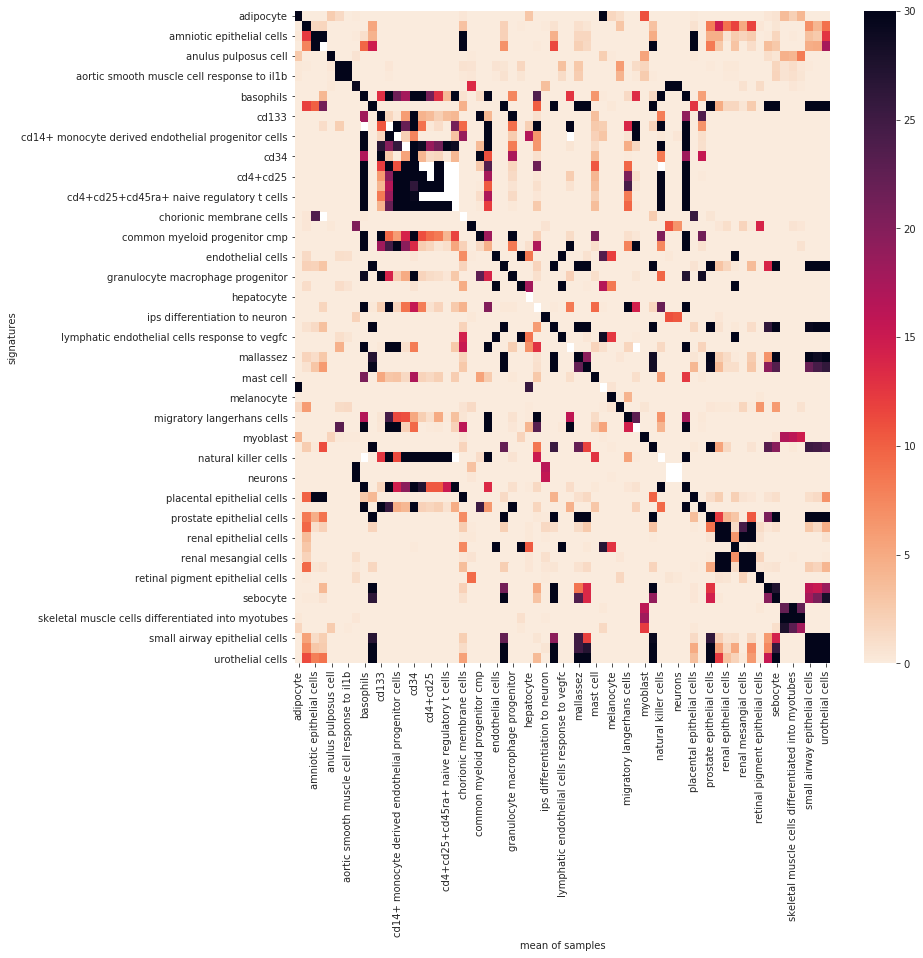

In [19]:
fig, ax = subplots(figsize=(12,12))
sns.heatmap(avg_fil.loc[:, avg_fil.index], ax=ax, annot=False, annot_kws={"size": 9}, vmin=0, vmax=30, cmap=sns.cm.rocket_r);
ax.set_ylabel("signatures")
ax.set_xlabel("mean of samples")

## filter samples and re-calculate signatures

We assume, that samples on which we were not able to calculate signatures are *bad* samples. Here we generate a list of the underlying sample ids, s.t. we can exclude them from a the dataset. 

In the next step, we calculate the signatures on the *good* samples (using both folds) to export them as gmt file. 

In [20]:
def get_id(name): 
    RGX = re.compile(r'CNhs(\d+)\.(.+)')
    return RGX.search(name).group()

In [21]:
filtered = pd.Series(target).isin(avg_fil.index).as_matrix()
col_vars = pd.read_csv('../data/pygenesig/primary_col_vars.csv', index_col=0)
col_vars = col_vars.assign(ora_id=col_vars.name_orig.apply(get_id))
# reorder columns
cols = col_vars.columns.tolist()
cols = cols[-3:][::-1] + cols[:-3]
col_vars = col_vars[cols]

/home/sturm/.conda/envs/fantom5-2/lib/python3.5/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


In [22]:
col_var_sets = {
    "good": col_vars[filtered],
    "bad":  col_vars[~filtered]
}

In [23]:
col_var_sets["good"]

,ora_id,type_coarse,type_fine,biol_rep,donor,lib_id,name,name_orig,obo_id,sample_type,tech_rep,time
74,CNhs11051.11376-118A8,adipocyte,adipocyte - breast,True,donor1,CNhs11051,"Adipocyte - breast, donor1","tpm of Adipocyte - breast, donor1.CNhs11051.11...",FF:11376-118A8,primary cell,False,NaN
75,CNhs11969.11327-117E4,adipocyte,adipocyte - breast,True,donor2,CNhs11969,"Adipocyte - breast, donor2","tpm of Adipocyte - breast, donor2.CNhs11969.11...",FF:11327-117E4,primary cell,False,NaN
76,CNhs11054.11473-119C6,adipocyte,adipocyte - omental,True,donor1,CNhs11054,"Adipocyte - omental, donor1","tpm of Adipocyte - omental, donor1.CNhs11054.1...",FF:11473-119C6,primary cell,False,NaN
77,CNhs12067.11474-119C7,adipocyte,adipocyte - omental,True,donor2,CNhs12067,"Adipocyte - omental, donor2","tpm of Adipocyte - omental, donor2.CNhs12067.1...",FF:11474-119C7,primary cell,False,NaN
78,CNhs12068.11475-119C8,adipocyte,adipocyte - omental,True,donor3,CNhs12068,"Adipocyte - omental, donor3","tpm of Adipocyte - omental, donor3.CNhs12068.1...",FF:11475-119C8,primary cell,False,NaN
79,CNhs12069.11476-119C9,adipocyte,adipocyte - perirenal,True,donor1,CNhs12069,"Adipocyte - perirenal, donor1","tpm of Adipocyte - perirenal, donor1.CNhs12069...",FF:11476-119C9,primary cell,False,NaN
80,CNhs12494.11259-116F8,adipocyte,adipocyte - subcutaneous,True,donor1,CNhs12494,"Adipocyte - subcutaneous, donor1","tpm of Adipocyte - subcutaneous, donor1.CNhs12...",FF:11259-116F8,primary cell,False,NaN
81,CNhs11371.11336-117F4,adipocyte,adipocyte - subcutaneous,True,donor2,CNhs11371,"Adipocyte - subcutaneous, donor2","tpm of Adipocyte - subcutaneous, donor2.CNhs11...",FF:11336-117F4,primary cell,False,NaN
82,CNhs12017.11408-118E4,adipocyte,adipocyte - subcutaneous,True,donor3,CNhs12017,"Adipocyte - subcutaneous, donor3","tpm of Adipocyte - subcutaneous, donor3.CNhs12...",FF:11408-118E4,primary cell,False,NaN
95,CNhs11325.11510-119G7,alveolar epithelial cells,alveolar epithelial cells,True,donor1,CNhs11325,"Alveolar Epithelial Cells, donor1","tpm of Alveolar Epithelial Cells, donor1.CNhs1...",FF:11510-119G7,primary cell,False,NaN


In [24]:
[(qual, cvs.shape) for qual, cvs in col_var_sets.items()]

[('bad', (320, 12)), ('good', (454, 12))]

In [25]:
col_vars.shape

(774, 12)

### make signatures

In [26]:
expr_sets = {
    "good": {},
    "bad": {}
}
for method, tmp_expr in expr.items():
    expr_sets["good"][method] = tmp_expr[:, filtered]
    expr_sets["bad"][method] = tmp_expr[:, ~filtered]

target_sets = {
    "good": target[filtered],
    "bad": target[~filtered]
}
# init result dict
results = {k: {k2: {} for k2 in v} for k, v in expr_sets.items()}

In [27]:
expr_sets["good"]["by_promotor"].shape, target_sets["good"].shape

((91036, 454), (454,))

In [28]:
def mk_and_evaluate_signatures(expr, target):
    sg = GiniSignatureGenerator(expr, target, aggregate_fun=np.median, **sg_kwargs)
    st = BioQCSignatureTester(expr, target)
    signatures = sg.mk_signatures()
    rogini = sg.get_rogini_format()
    scores = st.score_signatures(signatures)
    return signatures, rogini, scores

In [29]:
for quality, target in target_sets.items(): 
    for method, exprs in expr_sets[quality].items():
        results[quality][method] = dict(zip(["signatures", "rogini", "scores"], mk_and_evaluate_signatures(exprs, target)))

/home/sturm/projects/2019/pygenesig/pygenesig/validation.py:115: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if not np.issubdtype(expr.dtype, int) and not np.issubdtype(expr.dtype, float):
/home/sturm/projects/2019/pygenesig/pygenesig/validation.py:115: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(expr.dtype, int) and not np.issubdtype(expr.dtype, float):
/home/sturm/projects/2019/pygenesig/pygenesig/validation.py:204: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if not np.issubdtype(expr.dtype, int) and not np.issubdtype(expr.dtype, float):
/home/sturm/projects/201

#### test sigantures against themselves
did everything work as expected? 

We should expect scores at least as good as in the cross-validation, as we test on the same data on which we train. 

In [30]:
scores_df = pd.DataFrame(np.transpose(results["good"]["by_promotor"]["scores"]))
scores_df.columns = st.sort_signatures(results["good"]["by_promotor"]["signatures"])
scores_df['tissue'] = pd.Series(target_sets["good"])
scores_per_sig = scores_df.groupby('tissue').mean().transpose()

Text(0.5, 87.0, 'mean of samples')

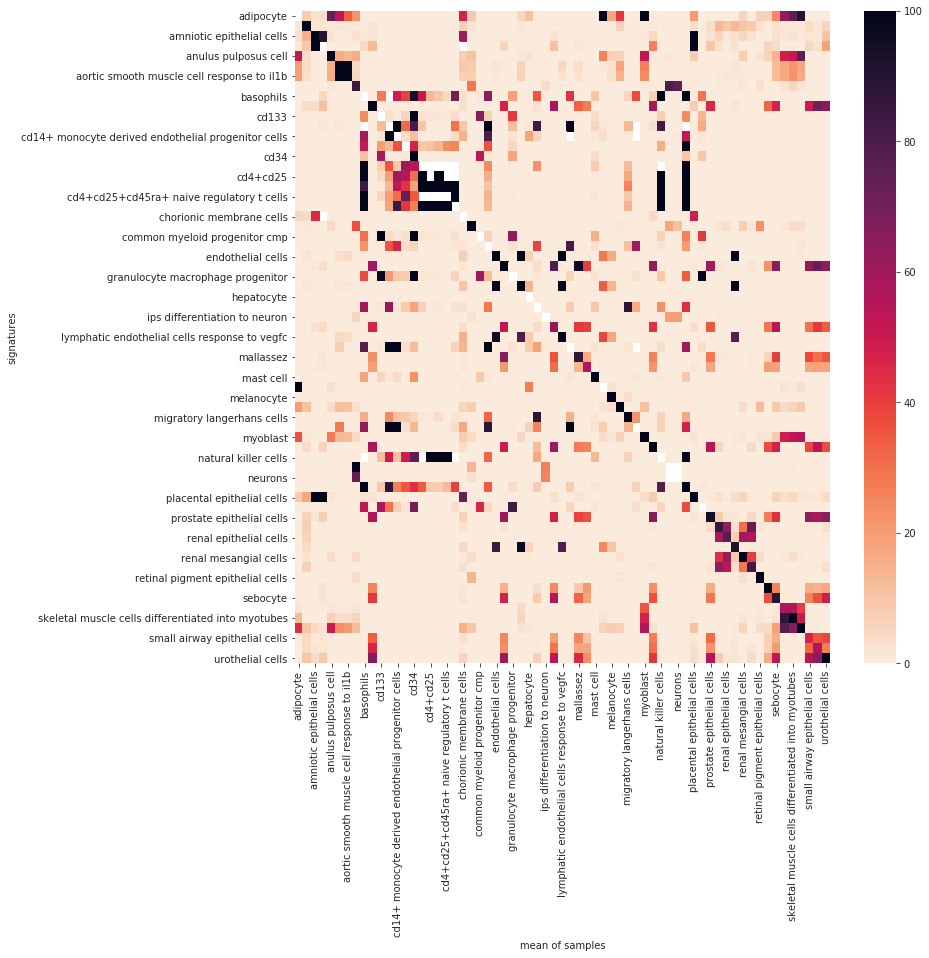

In [31]:
fig, ax = subplots(figsize=(12,12))
sns.heatmap(scores_per_sig, ax=ax, annot=False, annot_kws={"size": 9}, vmin=0, vmax=100, cmap=sns.cm.rocket_r)
ax.set_ylabel("signatures")
ax.set_xlabel("mean of samples")

## export signatures

### translate identifiers

In [32]:
rosetta = {
    "by_promotor": dict(zip(fdata["by_promotor"].index, fdata["by_promotor"].short_description)),
    "by_gene_sum":  dict(zip(fdata["by_gene_sum"].index, fdata["by_gene_sum"].ora_id))
}

In [33]:
rogini = {k: {k2: {} for k2 in v} for k, v in expr_sets.items()}
for quality in rogini:
    for method in rogini[quality]:
        tmp_rogini = results[quality][method]["rogini"]
        rogini[quality][method] = tmp_rogini.assign(GENEID=tmp_rogini.GENEID.apply(lambda x: rosetta[method][x]))

In [34]:
gct = {k: {k2: {} for k2 in v} for k, v in expr_sets.items()}
for quality in gct:
    for method in gct[quality]:
        gct[quality][method] = pd.concat([fdata[method], pd.DataFrame(expr_sets[quality][method])], axis=1)

### write files

In [37]:
os.makedirs("../results/", exist_ok=True)
for quality in expr_sets:
    qt = "hq" if quality == "good" else "lq"
    col_var_sets[quality].to_csv("../results/primary.{}.sample_meta.tsv".format(qt), index=False, sep='\t')
    for method in expr_sets[quality]:
        os.makedirs("../results/{}/".format(method), exist_ok=True)
        gct[quality][method].to_csv("../results/{}/primary.{}.gct".format(method, qt), index=False, sep="\t")
        rogini[quality][method].to_csv("../results/{}/primary.{}.gini".format(method, qt), index=False, sep='\t')